# Importig notebooks
# Kitti Data Handler

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import csv
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform
import os
import sys
import time
from numpy import ma
from math import ceil
import math

# Kitti Handler File

In [2]:
class FrameCalib:
    """Frame Calibration

    Fields:
        p0-p3: (3, 4) Camera P matrices. Contains extrinsic and intrinsic parameters.
        r0_rect: (3, 3) Rectification matrix
        velo_to_cam: (3, 4) Transformation matrix from velodyne to cam coordinate
            Point_Camera = P_cam * R0_rect * Tr_velo_to_cam * Point_Velodyne
        """

    def __init__(self):
        self.p0 = []
        self.p1 = []
        self.p2 = []
        self.p3 = []
        self.r0_rect = []
        self.velo_to_cam = []


def read_frame_calib(calib_file_path):
    """Reads the calibration file for a sample

    Args:
        calib_file_path: calibration file path

    Returns:
        frame_calib: FrameCalib frame calibration
    """

    data_file = open(calib_file_path, 'r')
    data_reader = csv.reader(data_file, delimiter=' ')
    data = []

    for row in data_reader:
        data.append(row)

    data_file.close()

    p_all = []

    for i in range(4):
        p = data[i]
        p = p[1:]
        p = [float(p[i]) for i in range(len(p))]
        p = np.reshape(p, (3, 4))
        p_all.append(p)

    frame_calib = FrameCalib()
    frame_calib.p0 = p_all[0]
    frame_calib.p1 = p_all[1]
    frame_calib.p2 = p_all[2]
    frame_calib.p3 = p_all[3]

    # Read in rectification matrix
    tr_rect = data[4]
    tr_rect = tr_rect[1:]
    tr_rect = [float(tr_rect[i]) for i in range(len(tr_rect))]
    frame_calib.r0_rect = np.reshape(tr_rect, (3, 3))

    # Read in velodyne to cam matrix
    tr_v2c = data[5]
    tr_v2c = tr_v2c[1:]
    tr_v2c = [float(tr_v2c[i]) for i in range(len(tr_v2c))]
    frame_calib.velo_to_cam = np.reshape(tr_v2c, (3, 4))

    return frame_calib


class StereoCalib:
    """Stereo Calibration

    Fields:
        baseline: distance between the two camera centers
        f: focal length
        k: (3, 3) intrinsic calibration matrix
        p: (3, 4) camera projection matrix
        center_u: camera origin u coordinate
        center_v: camera origin v coordinate
        """

    def __init__(self):
        self.baseline = 0.0
        self.f = 0.0
        self.k = []
        self.center_u = 0.0
        self.center_v = 0.0


def krt_from_p(p, fsign=1):
    """Factorize the projection matrix P as P=K*[R;t]
    and enforce the sign of the focal length to be fsign.


    Keyword Arguments:
    ------------------
    p : 3x4 list
        Camera Matrix.

    fsign : int
            Sign of the focal length.


    Returns:
    --------
    k : 3x3 list
        Intrinsic calibration matrix.

    r : 3x3 list
        Extrinsic rotation matrix.

    t : 1x3 list
        Extrinsic translation.
    """
    s = p[0:3, 3]
    q = np.linalg.inv(p[0:3, 0:3])
    u, b = np.linalg.qr(q)
    sgn = np.sign(b[2, 2])
    b = b * sgn
    s = s * sgn

    # If the focal length has wrong sign, change it
    # and change rotation matrix accordingly.
    if fsign * b[0, 0] < 0:
        e = [[-1, 0, 0], [0, 1, 0], [0, 0, 1]]
        b = np.matmul(e, b)
        u = np.matmul(u, e)

    if fsign * b[2, 2] < 0:
        e = [[1, 0, 0], [0, -1, 0], [0, 0, 1]]
        b = np.matmul(e, b)
        u = np.matmul(u, e)

    # If u is not a rotation matrix, fix it by flipping the sign.
    if np.linalg.det(u) < 0:
        u = -u
        s = -s

    r = np.matrix.transpose(u)
    t = np.matmul(b, s)
    k = np.linalg.inv(b)
    k = k / k[2, 2]

    # Sanity checks to ensure factorization is correct
    if np.linalg.det(r) < 0:
        print('Warning: R is not a rotation matrix.')

    if k[2, 2] < 0:
        print('Warning: K has a wrong sign.')

    return k, r, t


def get_stereo_calibration(left_cam_mat, right_cam_mat):
    """Extract parameters required to transform disparity image to 3D point
    cloud.

    Keyword Arguments:
    ------------------
    left_cam_mat : 3x4 list
                   Left Camera Matrix.

    right_cam_mat : 3x4 list
                   Right Camera Matrix.


    Returns:
    --------
    stereo_calibration_info : Instance of StereoCalibrationData class
                              Placeholder for stereo calibration parameters.
    """

    stereo_calib = StereoCalib()
    k_left, r_left, t_left = krt_from_p(left_cam_mat)
    _, _, t_right = krt_from_p(right_cam_mat)

    stereo_calib.baseline = abs(t_left[0] - t_right[0])
    stereo_calib.f = k_left[0, 0]
    stereo_calib.k = k_left
    stereo_calib.center_u = k_left[0, 2]
    stereo_calib.center_v = k_left[1, 2]

    return stereo_calib


class ObjectLabel:
    """Object Label

    Fields:
        type (str): Object type, one of
            'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting',
            'Cyclist', 'Tram', 'Misc', or 'DontCare'
        truncation (float): Truncation level, float from 0 (non-truncated) to 1 (truncated),
            where truncated refers to the object leaving image boundaries
        occlusion (int): Occlusion level,  indicating occlusion state:
            0 = fully visible,
            1 = partly occluded,
            2 = largely occluded,
            3 = unknown
        alpha (float): Observation angle of object [-pi, pi]
        x1, y1, x2, y2 (float): 2D bounding box of object in the image. (top left, bottom right)
        h, w, l: 3D object dimensions: height, width, length (in meters)
        t: 3D object centroid x, y, z in camera coordinates (in meters)
        ry: Rotation around Y-axis in camera coordinates [-pi, pi]
        score: Only for results, indicating confidence in detection, needed for p/r curves.
    """

    def __init__(self):
        self.type = None  # Type of object
        self.truncation = 0.0
        self.occlusion = 0
        self.alpha = 0.0
        self.x1 = 0.0
        self.y1 = 0.0
        self.x2 = 0.0
        self.y2 = 0.0
        self.h = 0.0
        self.w = 0.0
        self.l = 0.0
        self.t = (0.0, 0.0, 0.0)
        self.ry = 0.0
        self.score = 0.0


def read_labels(label_dir, sample_name):
    """Reads in label data file from Kitti Dataset
    Args:
        label_dir: label directory
        sample_name: sample_name
    Returns:
        obj_list: list of ObjectLabels
    """

    # Check label file
    label_path = label_dir + '/{}.txt'.format(sample_name)

    if not os.path.exists(label_path):
        raise FileNotFoundError('Label file could not be found:', label_path)
    if os.stat(label_path).st_size == 0:
        return []

    labels = np.loadtxt(label_path, delimiter=' ', dtype=str, ndmin=2)
    num_rows, num_cols = labels.shape
    if num_cols not in [15, 16]:
        raise ValueError('Invalid label format')

    num_labels = num_rows
    is_results = num_cols == 16

    obj_list = []
    for obj_idx in np.arange(num_labels):
        obj = ObjectLabel()

        # Fill in the object list
        obj.type = labels[obj_idx, 0]
        obj.truncation = float(labels[obj_idx, 1])
        obj.occlusion = float(labels[obj_idx, 2])
        obj.alpha = float(labels[obj_idx, 3])

        obj.x1, obj.y1, obj.x2, obj.y2 = (labels[obj_idx, 4:8]).astype(np.float32)
        obj.h, obj.w, obj.l = (labels[obj_idx, 8:11]).astype(np.float32)
        obj.t = (labels[obj_idx, 11:14]).astype(np.float32)
        obj.ry = float(labels[obj_idx, 14])

        if is_results:
            obj.score = float(labels[obj_idx, 15])
        else:
            obj.score = 0.0

        obj_list.append(obj)

    return np.asarray(obj_list)

# Part 1 Estimate Depth

In [3]:
def test_main_part1():

    ################
    # Options
    ################
    # Input dir and output dir

    disp_dir = 'data\\test\\disparity'
    output_dir = 'data\\test\\est_depth'
    calib_dir = 'data\\test\calib'
    sample_list = ['000011', '000012', '000013', '000014', '000015']
    ################

    for sample_name in sample_list:
        
        # Read disparity map
        disp_dir_path = '.\\'+disp_dir +'\\' + sample_name + '.png'
        disparity_map = cv2.imread(disp_dir_path,cv2.IMREAD_GRAYSCALE)
        
        # Uncomment below code to view the disparity maps in Jupyter Notebook
        #plt.imshow(disp_map, cmap = 'gray')
        #plt.show()
        
        # Read calibration info
        frame_calib_path = calib_dir +'\\' + sample_name + '.txt'
        frame_calib = read_frame_calib(frame_calib_path)
        
        # Calculate depth (z = f*B/disp)
        stereo_calib = get_stereo_calibration(frame_calib.p2, frame_calib.p3)
        baseline = stereo_calib.baseline
        f = stereo_calib.f
        focus_base = baseline*f
        
        depth = np.zeros(disparity_map.shape, dtype = float)
        
        #print(disparity_map.shape)
        
        # We calculate depth using disparity ONLY for values in disparity matrix where disparity is not equal to 0
        depth[disparity_map != 0] = focus_base / disparity_map[disparity_map != 0]
        depth = depth.astype(int)

        #print(depth.shape)
        #print(depth[disparity_map != 0])
        #print(depth)
        
        depth[np.logical_or(depth > 80, depth < 0.1)] = 0
        
        # Save depth map
        
        try:
            os.mkdir(output_dir)
            cv2.imwrite(output_dir+'\\'+sample_name+'.png',depth)
        except:
            cv2.imwrite(output_dir+'\\'+sample_name+'.png',depth)

In [4]:
if __name__ == '__main__':
    test_main_part1()

### Traing Code for Part 1

# Part 2 Yolo

For the YOLOV3 section we used a threshold value of 0.5 and a confidence value of 0.50. This gave us the best results and keeping threshold to minimuma for the IOUs.

In [5]:
# USAGE
# python part2_yolo.py --image images/baggage_claim.jpg --yolo yolo

# import the necessary packages


###########################################################
# OPTIONS
###########################################################

image_path = 'data\\test\\left\\'
yolo_dir = 'yolo'
sample_list = ['000011', '000012', '000013', '000014', '000015']
# minimum probability to filter weak detections
confidence_th = 0.50

# threshold when applyong non-maxima suppression
threshold = 0.50
###########################################################

for sample_name in sample_list:
    
    # load the COCO class labels our YOLO model was trained on
    labelsPath = os.path.sep.join([yolo_dir, "coco.names"])
    LABELS = open(labelsPath).read().strip().split("\n")

    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
                               dtype="uint8")

    # derive the paths to the YOLO weights and model configurationY
    weightsPath = os.path.sep.join([yolo_dir, "yolov3.weights"])
    configPath = os.path.sep.join([yolo_dir, "yolov3.cfg"])

    # load our YOLO object detector trained on COCO dataset (80 classes)
    print("[INFO] loading YOLO from disk...")
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

    # load our input image and grab its spatial dimensions
    image = cv2.imread(image_path+sample_name+'.png')
    (H, W) = image.shape[:2]

    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()

    # show timing information on YOLO
    print("[INFO] YOLO took {:.6f} seconds".format(end - start))

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > confidence_th:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_th,
                            threshold)
    
    try:
        os.mkdir('data\\test\\yolo_bbox\\')
    except:
        pass
    
    
    
    with open('data\\test\\yolo_bbox\\'+sample_name+'.txt','w') as f:
        
        # ensure at least one detection exists
        if len(idxs) > 0:
            # loop over the indexes we are keeping
            for i in idxs.flatten():
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])

                # draw a bounding box rectangle and label on the image
                color = [int(c) for c in COLORS[classIDs[i]]]
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color, 2)
                
                if LABELS[classIDs[i]] == 'car' or LABELS[classIDs[i]] == 'Car':
                    if x < 0:
                        x = 0
                    elif y < 0:
                        y = 0
                    _ = 0
                    f.write('{} {} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n'.format(LABELS[classIDs[i]],_,_,_,x,y,x + w,y + h,_,_,_,_,_,_,_,_))   
                                                                                  
                    
    # show the output image
    cv2.imshow(sample_name, image)
    cv2.imwrite(os.path.join('data\\test\\yolo_bbox\\',sample_name + ".png"),image)
    
    plt.show()
    cv2.waitKey(0)
    


[INFO] loading YOLO from disk...
[INFO] YOLO took 1.084015 seconds
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.828163 seconds
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.816754 seconds
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.870564 seconds
[INFO] loading YOLO from disk...
[INFO] YOLO took 0.941253 seconds


### Yolo Part 2 Training Code

# Part 3: Segmentation

For segmentation we have 2 methods. 
1. First option used is the mask library in numpy and calculating mask using that
2. The second method was just using numpy matrices


For distance threshold when calculating the mask there were 2 threshold set.
1. Minimum threshold 
2. Maximum threshold

These threshold based on the value difference between the depth map and the average depth map of the detected bounding box
selected the pixel and changed them to 0 (black)

To select the min/max threshold values we defined them based on average depth values based on where they lied in the range.
Average depth was split into the following ranges:
1. 0 to 8
2. 8 to 10
3. 10 to 15
4. 15 to 20
5. 20 to 30 
6. 30 to 40
7. 40 to 50
8. 50 to 60
9. 60+

Based on the above ranges different threshold values were set.


Please note: that a signle depth distance threshold value was also experimented with however, for those precision and recall values were not that great.

#### Defining fucntions to calculate Precision and Recall

In [6]:
def map_precision(target, ground_truth):
    # TP: True Positive
    # FP: False Positive
    ground_truth[ground_truth < 10 ]=0
    TP = np.sum(target == ground_truth)
    #print("TP: ", TP)
    
    FP = np.sum([ tr == 0 and gt == 255 for (tr,gt) in zip(target,ground_truth)])
    #print("FP: ", FP)
    
    return TP/(TP+FP)

def map_recall(target, ground_truth):
    # TP: True Positive
    # FP: False Negative
    #ground_truth[ground_truth < 10 ]=0
    TP = np.sum(target == ground_truth)
    FN = np.sum([ tr == 255 and gt == 0 for (tr,gt) in zip(target,ground_truth)])
    
    return TP/(TP+FN)

#### Test

In [7]:
def test_main_part3():

    ################
    # Options
    ################
    # Input dir and output dir
    
   
    depth_dir = 'data\\test\\est_depth'
    label_dir = 'data\\test\\yolo_bbox'
    image_dir = 'data\\test\\left'
    output_dir = 'data\\test\\est_segmentation'
   
    sample_list = ['000011', '000012', '000013', '000014', '000015']

    ################

    for sample_name in sample_list:
        
        # Read depth map
        depth_path = depth_dir+'\\'+sample_name+'.png'
        depth_map =  cv2.imread(depth_path,cv2.IMREAD_GRAYSCALE)
        #print(depth_map)        
        
        # Print the image Name
        print("Image: ",sample_name)
        
        total_precision = 0
        total_recall = 0
        count = 0
        
        # Discard depths less than 10cm from the camera
        depth_map[depth_map < 0.1] = 0
        
        # Read 2d bbox
        bbox = read_labels(label_dir, sample_name)
        image_mask = np.ones_like(depth_map) * 255
        
        # For each bbox
        for label in bbox:
            
            #check if the label is Car or not
            if ((label.type == 'Car')or (label.type == 'car')):
                
                #print(sample_name+" "+label.type)
                
                # Estimate the average depth of the objects
                
                # Extract the detected car's location from the depth map
                bbox_depth = depth_map[int(label.y1):int(label.y2)+1, int(label.x1):int(label.x2)+1]
                
                # Calculate average of the detected car's depth map (within the bounding boxes)
                try:
                    average_depth = np.nanmean(np.nanmean(np.where(bbox_depth!=0,bbox_depth,np.nan),1))
                except:
                    average_depth = np.mean(bbox_depth, axis=(0 , 1))
                if(math.isnan(average_depth)):
                    continue
                print("Average Depth: ", average_depth)

                # Find the pixels within a certain distance from the centroid
                
                # declare requried variable to calculate distance for pixels
                distance_range_min = 0
                distance_range_max = 0
                
                # Selecting istance threshold values (min/max) based on average depth value
                
                avg_depth = int(ceil(average_depth))
                if avg_depth <= 8:
                    distance_range_min = 2
                    distance_range_max = 3
                elif avg_depth > 8 and avg_depth <= 10:
                    distance_range_min = 3
                    distance_range_max = 2
                elif avg_depth > 10 and avg_depth <= 15:
                    distance_range_min = 3
                    distance_range_max = 3
                elif avg_depth > 15 and avg_depth <= 20:
                    distance_range_min = 10
                    distance_range_max = 15
                elif avg_depth > 20 and avg_depth <= 30:
                    distance_range_min = 8
                    distance_range_max = 8
                elif avg_depth > 30 and avg_depth <= 40:
                    distance_range_min = 8
                    distance_range_max = 9
                elif avg_depth > 40 and avg_depth <= 50:
                    distance_range_min = 5
                    distance_range_max = 7
                elif avg_depth > 50 and avg_depth <= 60:
                    distance_range_min = 10
                    distance_range_max = 15
                else:
                    distance_range_min = 10
                    distance_range_max = 15
                    
                depth_min_range = average_depth - distance_range_min
                depth_max_range = average_depth + distance_range_max
                
                # Checking the threshold values selected
                #print("Threshold Values: ",depth_min_range," ",depth_max_range)
                
                # Checking the difference between the bbox_depth and averages depth value
                #print("Difference")
                #print((bbox_depth - average_depth))
                
                # looking at the image of the difference
                #plt.imshow((bbox_depth - average_depth), cmap = 'gray')
                #plt.show()     

                # Using Numpy to mask matrix positions that are within range.
                box_mask = ma.masked_inside(bbox_depth, depth_min_range, depth_max_range)
                
                # Uncomment below code for checking the image
                #plt.imshow(mask1,cmap='gray')
                #plt.show()
                #print(mask1)
                
                # Apply Mask to change the calculate the mask location based on integer values
                box_mask_2 = box_mask.mask.astype(int)

                # Uncomment below code for checking the image
                #plt.imshow(box_mask_2,cmap='gray')
                #plt.show()
                #print(box_mask_2)
                
                # Convert image into Black and White for the segmentaion mask
                box_mask_2[box_mask_2 == 0] = 255
                box_mask_2[box_mask_2 == 1] = 0
                
                #image_mask[int(label.y1):int(label.y2)+1, int(label.x1):int(label.x2)+1] = int_mask
                
                # Uncomment below code for checking the image
                #plt.imshow(box_mask_2,cmap='gray')
                #plt.show()
                
                #print("Mask section Shape: ",box_mask_2.shape)
                #print(box_mask_2)               
                
                
                mask_shape = box_mask_2.shape
                #print(mask_shape)
                

                check = image_mask[int(label.y1):int(label.y2)+1, int(label.x1):int(label.x2)+1].flatten()
                box_mask_2 = box_mask_2.flatten()
                image_mask[int(label.y1):int(label.y2)+1, int(label.x1):int(label.x2)+1] = np.array([b if a!=0 else a for a,b in zip(check,box_mask_2)]).reshape(mask_shape)
                est = image_mask[int(label.y1):int(label.y2)+1, int(label.x1):int(label.x2)+1].flatten()          


        plt.imshow(image_mask,cmap='gray')
        plt.show()
    
        
            
        # Save the segmentation mask
        try:
            os.mkdir(output_dir)
            cv2.imwrite(os.path.join(output_dir,sample_name + ".png"),image_mask)
        except:
            cv2.imwrite(os.path.join(output_dir,sample_name + ".png"),image_mask)
        
        

Image:  000011
Average Depth:  40.486272488755624


<ipython-input-7-f9062c15c80b>:54: RuntimeWarning: Mean of empty slice
  average_depth = np.nanmean(np.nanmean(np.where(bbox_depth!=0,bbox_depth,np.nan),1))


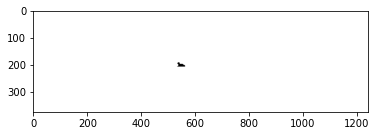

Image:  000012
Average Depth:  27.19789174601668


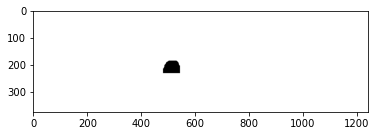

Image:  000013
Average Depth:  11.401811805961424
Average Depth:  19.832632345359055


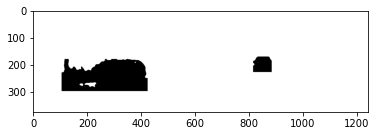

Image:  000014
Average Depth:  51.89955553599718


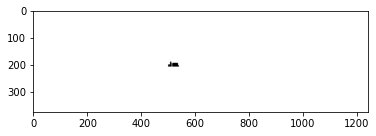

Image:  000015
Average Depth:  11.795729013254787
Average Depth:  21.536995376279524


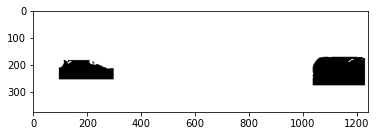

In [8]:
if __name__ == '__main__':
    test_main_part3()

# Segmentation TRAINING SECTION (Commented)
#### Part3: Training Code Method 1

if __name__ == '__main__':
    train_main1()

#### Part3: Training Code Method 2